In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.data import Dataset

from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
import torch.autograd as autograd

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import scipy.ndimage
from scipy.signal import savgol_filter

torch.manual_seed(8)

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__() ## importing class from super
        self.model = nn.Sequential(
            nn.Linear(1050, 512), ## Note this is because there is 1050 inputs
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2), #increased size for first layer
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            #nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2), #Uses ReLU activation
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            #nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1), #Last layer goes from 64 neurons to 1
            nn.Sigmoid(), ##using sigmoidal activation to create a single neuron output
        )
    def forward(self, x):
            output = self.model(x) #describes how the output of the model is calculated
            return output 

In [3]:
class Generator(nn.Module): # Inherits from the nn.Module
    def __init__(self, noise_dim = 100):
        super().__init__() ##allows you to create a nn architecture
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256), ## taking noise vector of 100 to have more diversity
            #nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            #nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2), # Leaky ReLU prevents overfitting, especially since the sample sets have been relatively small
            nn.Linear(512, 1024), 
            #nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1050),  # Output layer producing 1050 features
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        return output


In [4]:
class MOMADatasetHandler:
    #note this will only preprocess datasets that fit the same dimensions as the 2021 set
    def __init__(self, filepath, label_type):
        self.filepath = filepath
        self.label_type = label_type
        self.column_name = label_type + '_label'
        self.__training_data__ = pd.read_csv(filepath)
        self.__labels__ = None


    def get_all_labels(self):
        column_name = f'{self.label_type}_label'
        self.__labels__ = self.__training_data__[column_name].unique().tolist()
        print(self.__labels__)
        

    def get_label_data(self, label):
        return self.__training_data__.loc[self.__training_data__[self.column_name] == label].copy()

        #features = training_data.loc[training_data[COLUMN] == CATEGORY_TYPE].copy()

    def get_all_labels_data(self):
        data_array = []
        for label in self.__labels__:
            data_array.append(self.__training_data__[label].copy())

        return data_array

    def get_dataframe():

        return self.__training_data__

    def get_dataframe_diagnostic():
        return

        ## The plan is to try to store everything in an array of things
        
        #we are not training on any empty sets
        """
        if training_data.loc[training_data[COLUMN] == sample_label].empty:
            continue
        if training_data.loc[training_data[COLUMN] == sample_label].shape[0] < 512:
            not_enough.append((sample_label,training_data.loc[training_data[COLUMN] == sample_label].shape[0]))
            continue
       
        curr = training_data.loc[training_data[COLUMN] == sample_label].copy()
        print(sample_label, curr.shape)
        """


In [5]:
class GANDataHandler:
    
    
    def __init__(self, generator_path = None, discriminator_path = None, features = None, batch_size = 128, lr = .001):
        
        
        def load_models(generator_path, discriminator_path):
            # Initialize the models
            generator = Generator()
            discriminator = Discriminator()
    
            # Load the state dictionaries
            generator.load_state_dict(torch.load(generator_path))
            discriminator.load_state_dict(torch.load(discriminator_path))

            return generator, discriminator
        
        
        if generator_path is not None and discriminator_path is not None and features is not None:
            self.generator, self.discriminator = load_models(generator_path, discriminator_path)
            self.features = features

        elif features is not None and generator_path is None and discriminator_path is None:
            self.features = features # MS Data
            self.generator = None
            self.discriminator = None

        
        self.scaler = MinMaxScaler() # Scaler. Used to fit transform data for the GANS and inverse transform to transform it back to GANS "size"
        self.batch_size = batch_size # # of samples being input at a time
        self.lr = lr # Learning Rate of the GANS

        ## Preprocessing Variables ##
        # Real Data used for training #
        self.real_data = None 
        self.real_labels = None
        self.real_set = None
        self.real_data_loader = None  # Dataloader to be used in training
        self.USIDs = None # USIDS will be merged later
        self.metadata = None
        
        ## Training Metrics to be Displayed by Classification Report ##
        # Average Loss over all training 
        self.avg_loss_g = None
        self.avg_loss_d = None
        # Number of Epochs trained on
        self.num_epochs_trained = 0
        # Average Accuracy of the Discriminator
        self.avg_disc_acc = None
        self.avg_gen_acc = None


    
        

  
    """ preprocess_data()
    Preprocesses the features data by scaling and creates a DataLoader for use in model training or evaluation. Saves USIDS and Meta Data to be merged later.

    Steps:
    1. Scale the feature data using the scaler's fit_transform method.
    2. Generate labels for the real data.
    3. Create a dataset by zipping together the scaled data and the corresponding labels.
    4. Initialize a DataLoader with the created dataset, setting the batch size and shuffling the data.
    
    This method is used after GANS is created;

    test = GANDataHandler(ms_data)
    test.preprocess_data
    
    """
    def preprocess_data(self):
        
        self.metadata = self.features.loc[:,'Laser_Energy':'formationprocess_label']
        self.features.drop(self.features.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
        self.features.drop(self.features.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
        self.USIDs = self.features['USID'].copy()
        self.features = self.features.drop(columns = ['USID'])

        ## Preprocess data to be trained
        num_rows_to_drop = self.features.shape[0] % 512
        # Get the index of the rows to drop
        rows_to_drop = self.features.tail(num_rows_to_drop).index
        # Drop the rows
        self.features = self.features.drop(rows_to_drop)
        
        self.real_data = self.scaler.fit_transform(self.features)
        real_data_length = len(self.real_data)
        self.real_labels = torch.zeros(real_data_length)

        real_set = [ ## Zipping together labels and data to be used later
            (self.real_data[i], self.real_labels[i]) for i in range(real_data_length)
        ]
        
        self.real_data_loader = torch.utils.data.DataLoader(
            real_set, batch_size = self.batch_size, shuffle = True
        ) 
        
    """ display_features()
    Displays a graph of the feature data for a specified entry.

    This method plots the mass spectrometry data for a given entry, showing the intensity against the m/z (mass/charge ratio).

    Use:
    print(test.head()) #to find ids to input
    test.display_features(test_id)
    
    """
    def display_features(self, id):
        #entry = self.features[] ##Graphing of what our data should look like!
        print(self.features.head())
        entry = self.features.loc[id]
        plt.figure(figsize=(12, 6))
        plt.plot(entry)
        plt.title('Mass Spectrometry Data - 50th Entry')
        plt.xlabel('m/z (mass/charge ratio)')
        plt.ylabel('Intensity')
        plt.xticks(ticks=range(0, len(entry), 200))  # Show every 50th label

        plt.show()
    
    """ setup_optimizers()
    Sets up the loss function and optimizers for the discriminator and generator models.

    This method initializes the binary cross-entropy loss function and the Adam optimizers for both the discriminator and generator. 
    The learning rate for the generator's optimizer is set to be twice that of the discriminator's.

    Note: This is done within the train_model method, so this will not be needed to be called by the user
    """
    def setup_optimizers(self, discriminator, generator):
        loss_function = nn.BCELoss()
        optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = self.lr) ## Adam is the name of the optimizer we will use for the discriminator and generator
        optimizer_g = torch.optim.Adam(generator.parameters(), lr = self.lr * 2)

        return loss_function, optimizer_d, optimizer_g

    
    """ train_model()
    Trains the discriminator and generator models over a specified number of epochs.

    This method initializes the discriminator and generator models, sets up the optimizers and loss function,
    and trains the model.

    This method also keeps track of batch accuracy and other metrics to be displayed later
    
    Note: This method will be called by the user after creating the GANS and preprocessing the data
    """
    def train_model(self, num_epochs):
        discriminator = Discriminator()
        generator = Generator()
        loss_function, optimizer_d, optimizer_g = self.setup_optimizers(discriminator, generator)

        #Reset Batch Loss
        self.avg_loss_g, self.avg_loss_d = None, None
        self.avg_disc_acc, self.avg_gen_acc = None, None
        # Number of Epochs trained on
        self.num_epochs_trained = 0

        for epoch in range(num_epochs):

            NOISE_DIM = 100

            total_loss_d = 0
            total_loss_g = 0

            total_correct_d = 0
            total_samples_d = 0
            
            for n, (real_samples, _) in enumerate(self.real_data_loader):
                
                fake_labels = torch.zeros((self.batch_size, 1))
                real_labels = torch.ones((self.batch_size, 1))
                
                latent_space_samples = torch.randn((self.batch_size, NOISE_DIM))
                generated_samples = generator(latent_space_samples)
        
                all_samples = torch.cat((real_samples.to(torch.float32) , generated_samples.to(torch.float32)))
                all_sample_labels = torch.cat(
                    (real_labels, fake_labels)
                )
                all_sample_labels = all_sample_labels
                
                
                #Train the discriminator
                discriminator.zero_grad() # clear gradients at each step to avoid accumulation
                output_discriminator = discriminator(all_samples) #calculate output of the batch
                #print(output_discriminator.shape, all_sample_labels.shape)
                loss_discriminator = loss_function(
                    input = output_discriminator.view(-1), target = all_sample_labels.view(-1) ##loss function
                )
                loss_discriminator.backward() #calculate gradients to update weights (gradient descent)
                optimizer_d.step() #optimizer_discriminator.step()

                #calculate optimizer accuracy
                predicted_labels = (output_discriminator > 0.5).float()
                total_correct_d += (predicted_labels == all_sample_labels).sum().item()
                total_samples_d += all_sample_labels.size(0)
                
                #Time to train the generator
                
                #data for generator
                latent_space_samples = torch.randn((self.batch_size, NOISE_DIM))
        
                #Training the generator
                generator.zero_grad()
                generated_samples = generator(latent_space_samples)
                output_discriminator_generated = discriminator(generated_samples)
                loss_generator = loss_function(
                    output_discriminator_generated, real_labels
                )
                loss_generator.backward()
                optimizer_g.step()

                total_loss_d += loss_discriminator
                total_loss_g += loss_generator
                

                 # Show loss
                if epoch % 10 == 0 and n == 5:
                    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

            #save generator and discriminator
            self.generator = generator
            self.discriminator = discriminator
            
            #Update Loss with updated batch loss
            batch_len = len(self.real_data_loader)
            batch_loss_g = total_loss_g / batch_len
            batch_loss_d = total_loss_d / batch_len

            #Update Avg Discriminator and Generator Accuracy for the current batch:
            avg_disc_acc = total_correct_d / total_samples_d
            
            fake_labels_for_gen_acc = torch.ones((self.batch_size, 1))
            output_discriminator_generated = discriminator(generated_samples)
            gen_pred_labels = (output_discriminator_generated > 0.5).float()
            gen_acc = (gen_pred_labels == fake_labels_for_gen_acc).sum().item() / self.batch_size

            self.num_epochs_trained += 1
            
            if not self.avg_loss_g and not self.avg_loss_d:
                self.avg_loss_g = batch_loss_g
                self.avg_loss_d = batch_loss_d
                self.avg_disc_acc = avg_disc_acc
                self.avg_gen_acc = gen_acc
                
            else:
                self.avg_loss_g = (batch_loss_g + (self.avg_loss_g * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_loss_d = (batch_loss_d + (self.avg_loss_d * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_disc_acc = (avg_disc_acc + (self.avg_disc_acc * (self.num_epochs_trained - 1)))/self.num_epochs_trained
                self.avg_gen_acc = (gen_acc + (self.avg_gen_acc * (self.num_epochs_trained - 1)))/self.num_epochs_trained


    """ generate_samples()
    Generates synthetic samples using the trained generator model and saves them to a CSV file.

    This method generates samples from the latent space, transforms them back to the original scale,
    applies a moving average smoothing, and saves the results to a CSV file along with metadata.
    """
    def generate_samples(self, num_samples, num_batches = 1, smooth_filter = 'no_smooth'):
        filter_types = {'gauss', 'rolling', 'savitsky', 'no_smooth'}

        def moving_average(df, window_size):
            return df.rolling(window=window_size).mean()

        def gauss(df):
            return pd.DataFrame(scipy.ndimage.gaussian_filter(df.values, sigma=1), columns = df.columns) 

        def savitsky(df):
            POLYORDER = 3
            WINDOW_LENGTH = 10

            data_np = df.values
            smoothed_data_np = savgol_filter(data_np, window_length=WINDOW_LENGTH, polyorder=POLYORDER, axis=0)
            smoothed_df = pd.DataFrame(smoothed_data_np, columns=df.columns)
            return smoothed_df

        noise_dim = 100
        for batch in range(num_batches):
            latent_space_samples = torch.randn(num_samples, noise_dim) #100 is number of samples to make
            generated_samples = self.generator(latent_space_samples)
            generated_samples = generated_samples.detach()
            generated_samples = self.scaler.inverse_transform(generated_samples)
            graphed = generated_samples.clip(min = 0)
            
            
    
            # Example usage
            DF = pd.DataFrame(graphed)
            if smooth_filter in filter_types:
                if smooth_filter == 'rolling':
                    DF = moving_average(DF, window_size=5)
                elif smooth_filter == 'gauss':
                    DF = gauss(DF)
                elif smooth_filter == 'savitsky':
                    DF = savitsky(DF)
            else:
                smooth_filter = 'no_smooth'
    
        
            DF.insert(0, 'USID', self.USIDs)
            DF['USID'] = 'G' + DF['USID'].astype(str)
                
            for col in self.metadata.columns:
                DF[col] = self.metadata[col]
        
            ## Note this will be updated in later iterations
            CATEGORY_TYPE = 'CsI'
    
            if not os.path.exists('./generated_samples'):
                os.makedirs('./generated_samples')

            if num_batches == 1:
                DF.to_csv(f"./generated_samples/{CATEGORY_TYPE}_samples_{smooth_filter}.csv")
            else:
                DF.to_csv(f"./generated_samples/{CATEGORY_TYPE}_samples_{smooth_filter}_batch_{batch}.csv")

    
        
        
        
        # Select a few spectra to plot
        num_spectra_to_plot = 4
        spectra_indices = [ 8, 9, 10] # Change these indices to plot different spectra
        
        plt.figure(figsize=(12, 6))
        
        for i in spectra_indices:
            plt.plot(graphed[i], label=f'Spectrum {i+1}')
        
        plt.title("Mass Spectra")
        plt.xlabel("Mass/Charge (m/z)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.show()

    
    """ generate_classification_report()
    Generates and saves a classification report summarizing the training performance of the generator and discriminator models.

    This method prints the average generator and discriminator losses and accuracies, calculates the total number of samples trained,
    and saves these metrics to a CSV file.
    
    """
    def generate_classification_report(self, output_csv = 'classification_report.csv'):

        # Average Loss over all training 
        print(f"Average Generator Loss over {self.num_epochs_trained} Epochs: {self.avg_loss_g}")
        print(f"Average Discriminator Loss over {self.num_epochs_trained} Epochs: {self.avg_loss_d}")

        print(f"Average Generator Accuracy from the last train: {self.avg_gen_acc}")
        print(f"Average Discriminator Accuracy from the last train: {self.avg_disc_acc}")

        total_samples_trained = self.batch_size * self.num_epochs_trained

        with open(output_csv, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Metric', 'Value'])
                writer.writerow(['Average Generator Loss', self.avg_loss_g.item()])
                writer.writerow(['Average Discriminator Loss', self.avg_loss_d.item()])
                writer.writerow(['Average Generator Accuracy', self.avg_gen_acc])
                writer.writerow(['Average Discriminator Accuracy', self.avg_disc_acc])
                writer.writerow(['Total Samples Trained', total_samples_trained])
        
        print(f"Classification report saved to {output_csv}")
        # Average Accuracy of the Discriminator


    """ export_models()
    Exports the trained generator and discriminator models to the specified directory.

    This method saves the state dictionaries of the generator and discriminator models to the specified directory
    with filenames based on the given sample name.
    """
    def export_models(self, sample_name, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        generator_path = os.path.join(directory, f'{sample_name}_generator.pth')
        discriminator_path = os.path.join(directory, f'{sample_name}_discriminator.pth')
        
        torch.save(self.generator.state_dict(), generator_path)
        torch.save(self.discriminator.state_dict(), discriminator_path)
        
        print(f'Models saved in directory: {directory}')

       
   
    
       

### Victoria use this block to test out the generator

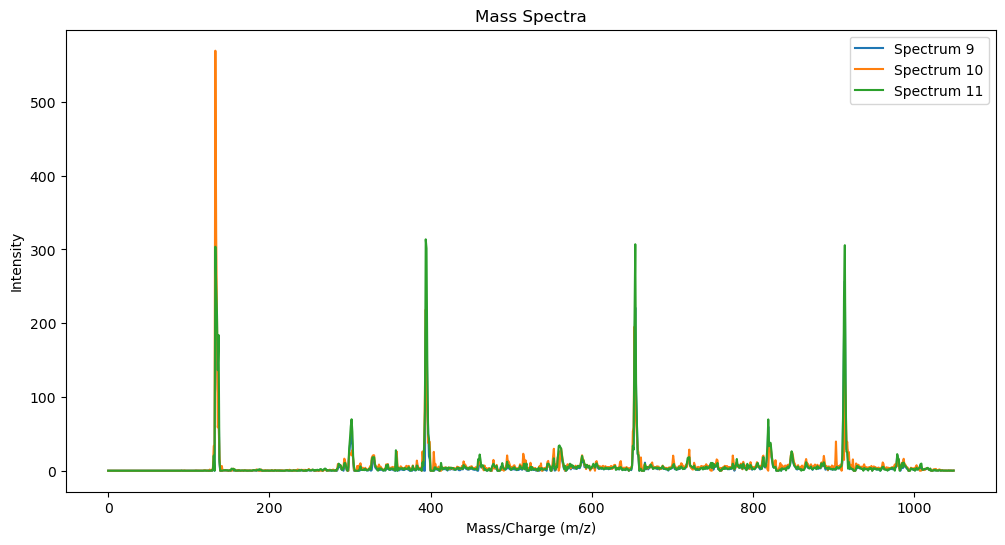

In [75]:
FILEPATH = './test_sample1.csv'
COLUMN = 'category_label'
CATEGORY_TYPE = 'CsI'

CsI = MOMADatasetHandler(FILEPATH, 'category')
features = CsI.get_label_data(CATEGORY_TYPE)
curr = GANDataHandler(generator_path = './CsI/CsI_generator.pth', discriminator_path = './CsI/CsI_discriminator.pth', features = features)
curr.preprocess_data()
curr.generate_samples(20)


   0  1  2  3  4  5  6  7  8  9  ...  1040  1041  1042  1043  1044  1045  \
0  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

   1046  1047  1048  1049  
0     0     0     0     0  
1     0     0     0     0  
2     0     0     0     0  
3     0     0     0     0  
4     0     0     0     0  

[5 rows x 1050 columns]


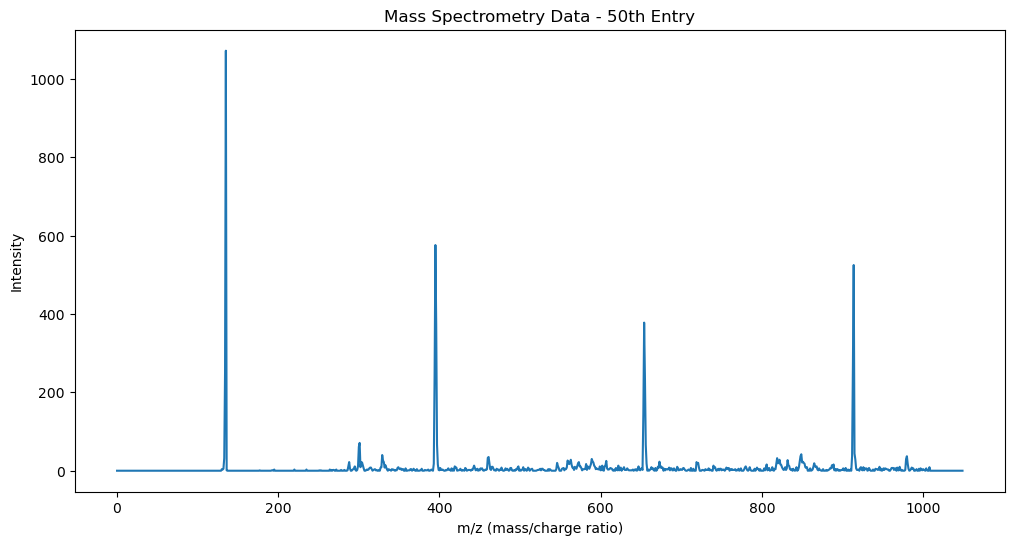

In [78]:
curr.display_features(4)

## Train a new GANS

In [6]:
FILEPATH = './test_sample1.csv'

xina_data = MOMADatasetHandler(FILEPATH, 'sample')
xina_data.get_all_labels()

['CsI', 'TiO2', 'Forsterite', 'Phosphorus', 'Rhodamine 6G', 'Nontronite', 'Gly+Ala+Ser mixture + CHCA', 'Gypsum', 'Butterfinger', 'Gabion Basalt', 'Valine in Jerosite', 'Yellowstone Green stream TLE', 'Yellowstone Green stream powder', 'Dolomite', 'Mix in Mont', 'Phe in Mont', 'Phthalic Acid in Mont', 'Atacama', 'Ferrosilite', 'Sanidine', 'Diopside', 'Chlorophyll A', 'Thin section (C coating)', 'Graphite', 'Magnetite', 'Phospholipids', 'MGDG', 'DGDG', 'Hopane', 'Glu in Mont', 'Saponite', 'Montmorillonite', 'Hematite', 'Mg Perc. in Mont', 'Phthalic Acid in Mont + Mg Perc.', 'AMP in Mont + Mg Perc.', 'Glu in Mont + Mg Perc.', 'Phe in Mont + Mg Perc.', 'Mix in Mont + Mg Perc.', 'Angiotensine+CHCA', 'Feldspar', 'Orthoclase', 'Augite', 'Enstatite', 'Magadi', 'Magadi kerogen', 'Ocean World Analog', 'BetaCarotene+FS121', 'CsI in Hematite', 'CsI in Mont', 'Kerogen (Type IV)', 'FeSO4.7H2O', 'Calcite', 'MnSO4', 'CaSiO3', 'Anhydrite', 'MgSO4', 'Epsomite']


elbow at 6


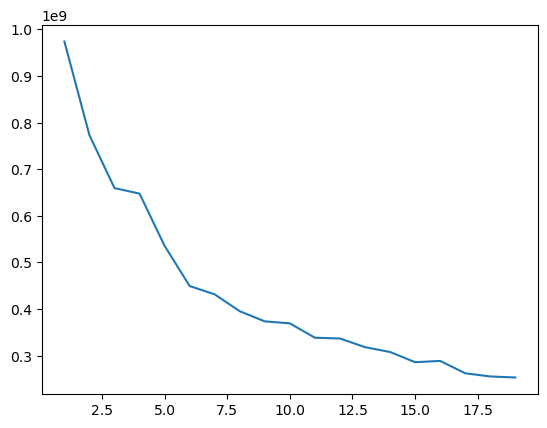

In [9]:
from kneed import KneeLocator  # You'll need to install kneed using `pip install kneed`

TiO2_data = xina_data.get_label_data('TiO2')
df = TiO2_data

df.drop(df.loc[:,'Laser_Energy':'formationprocess_label'].columns, axis = 1, inplace = True)
df.drop(df.loc[:,'1050':'2000'].columns, axis = 1, inplace = True)
USIDs = df['USID'].copy()
df = df.drop(columns = ['USID'])


from sklearn.cluster import KMeans
WCSS=[]
I = range(1, 20)
for i in I:
  kmeans=KMeans(n_clusters=i,init='k-means++')
  kmeans.fit(df)
  WCSS.append(kmeans.inertia_)
#print(WCSS)



plt.plot(range(1,20),WCSS)

kneedle = KneeLocator(I, WCSS, curve='convex', direction='decreasing')
best_k = kneedle.elbow
print(f"elbow at {best_k}")

kmeans = KMeans(n_clusters = 5, init = 'k-means++')
kmeans.fit(df)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_
## what is the best index to determine clusters
# num clusters = =



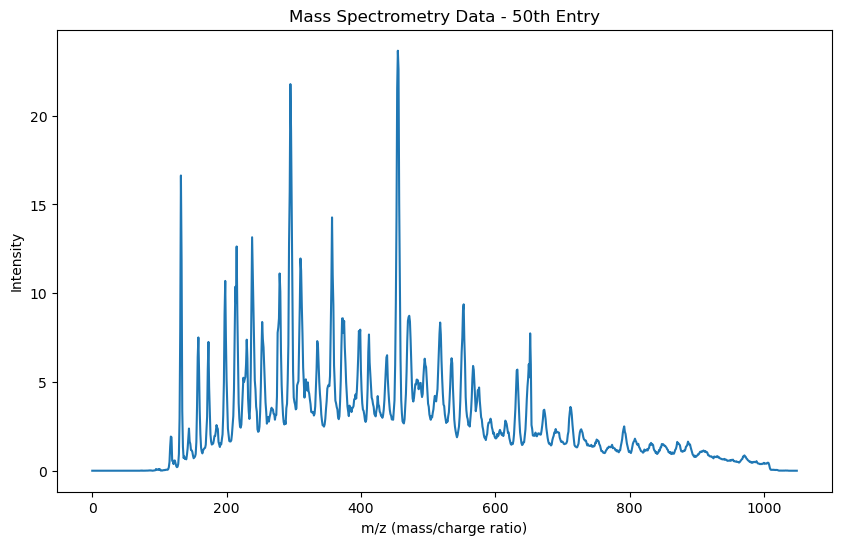

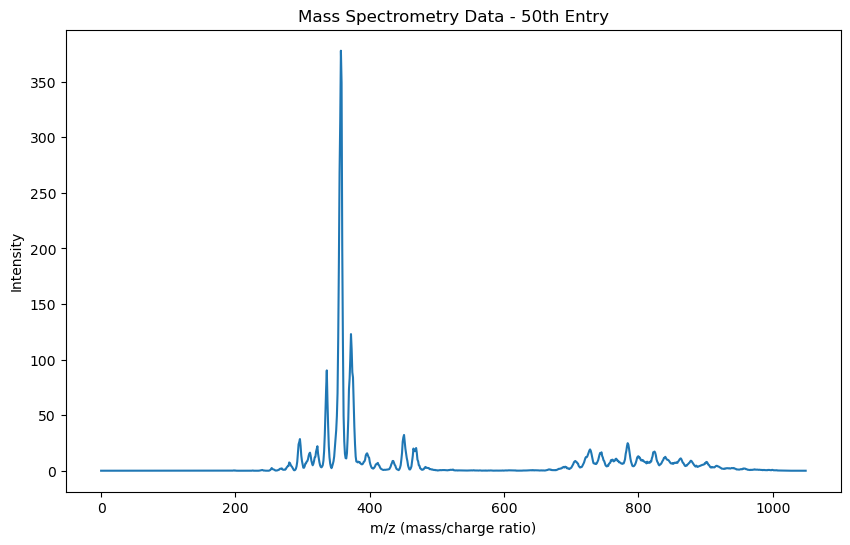

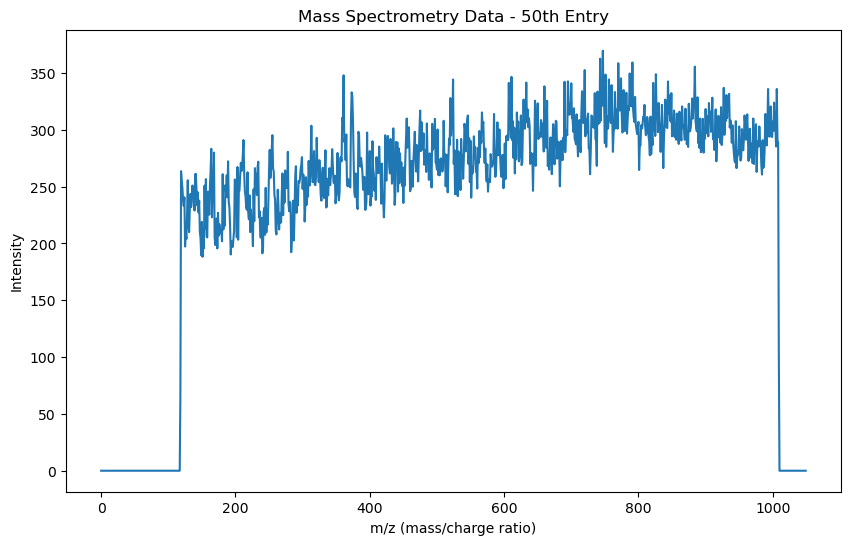

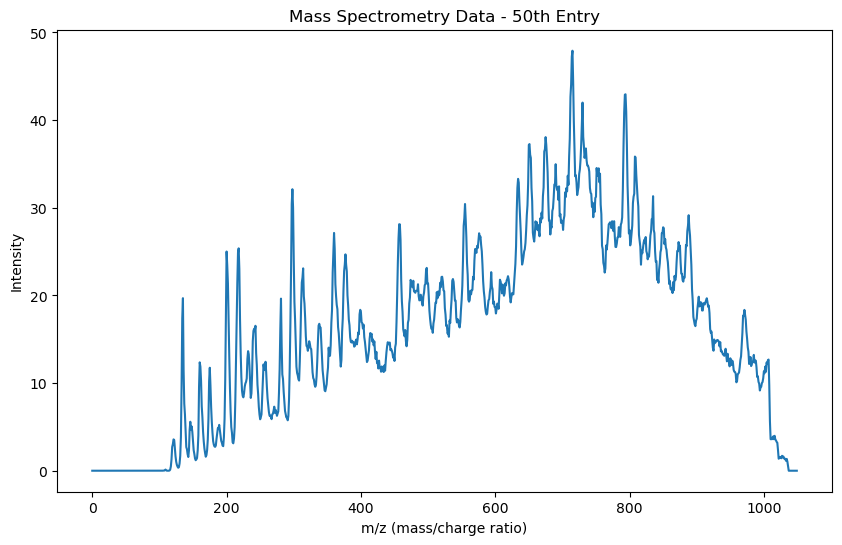

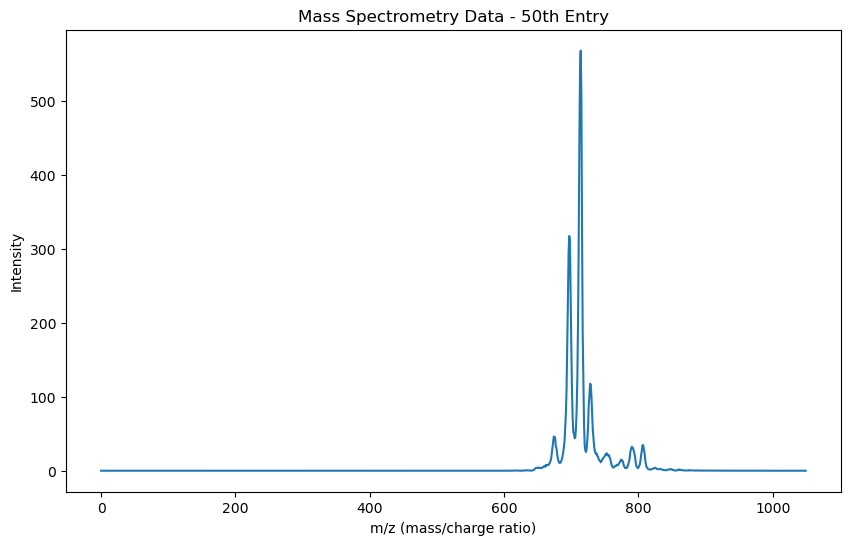

In [10]:
for cluster in cluster_centers:
    plt.figure(figsize=(10, 6))
    plt.plot(cluster)
    plt.title('Mass Spectrometry Data - 50th Entry')
    plt.xlabel('m/z (mass/charge ratio)')
    plt.ylabel('Intensity')
    plt.xticks(ticks=range(0, len(cluster), 200))  # Show every 50th label
    
    plt.show()

(2536, 1050) 0
(124, 1050) 1
(3, 1050) 2
(322, 1050) 3
(60, 1050) 4


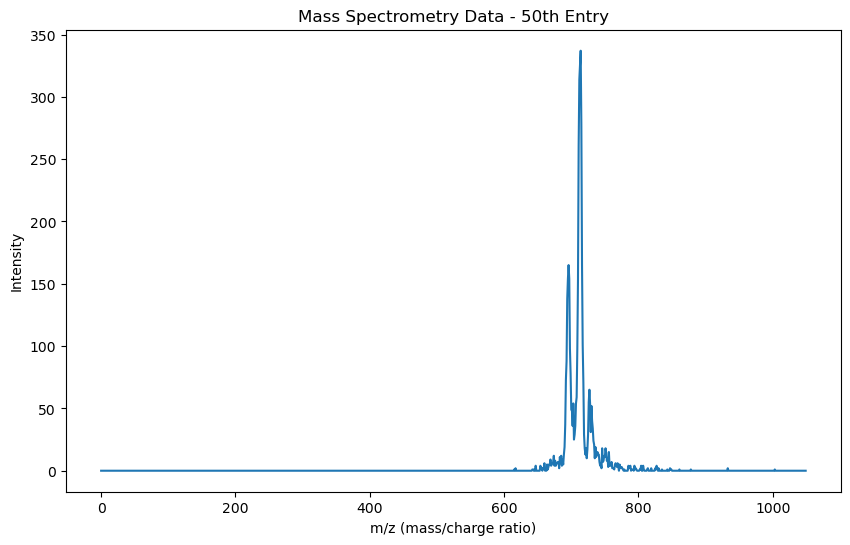

In [11]:
unique_labels = set()
for label in kmeans.labels_:
    if label not in unique_labels:
        unique_labels.add(label)

cluster_test = dict()
for label in unique_labels:
    cluster = df[kmeans.labels_ == label]
    cluster_test[label] = cluster
    print(cluster.shape, label)

cluster = cluster_test[4].iloc[0]
plt.figure(figsize=(10, 6))
plt.plot(cluster)
plt.title('Mass Spectrometry Data - 50th Entry')
plt.xlabel('m/z (mass/charge ratio)')
plt.ylabel('Intensity')
plt.xticks(ticks=range(0, len(cluster), 200))  # Show every 50th label

plt.show()

    

#Clusters are now stored, ready to be trained.

In [129]:
print(cluster_test.values())
Ti02 = MOMADatasetHandler(FILEPATH, '')

git a

dict_values([       0  1  2  3  4  5  6  7  8  9  ...  1040  1041  1042  1043  1044  1045  \
445    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
446    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
447    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
448    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
449    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
...   .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
4405   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4406   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4410   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4411   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
30917  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

       1046  1047  1048  1

## Sabrina Do Data Generation Methods

In [33]:
"""
Written by Sabrina Do
NASA GSFC Summer Internship 2023

Script to generate artificial spectra
"""

import numpy as np
import pandas as pd

import csv



""""
Functions for Data Augmentation
"""


def shift(input_array, degree_shift):
    """
    input:
        * input_array: 1D array
        * degree_shift (number between +/- 3), if +, shifts to the right
    output: 
        * 1D array that is shifted
    """
    degree_shift = min(degree_shift, 3)
    degree_shift = max(degree_shift, -3)
    return np.roll(input_array, degree_shift)


def randomizeIntensity(input_array, percentageIntensity):
    """
    input:
        * input_array: 1D array
        * percentageIntensity: int of the percentage to increase or decrease
    output:
        * 1D array with intensity increased
    """
    return input_array * ((percentageIntensity / 100) + 1)


def addNoise(input_array):
    """
    input: 
        * input_array: 1D array
    output:
        * 1D array with noise

    """
    len_array = len(input_array)
    # Random noise
    # random_noise = np.random.random((len_array,))
    gaussian_noise = np.random.normal(loc=0, scale=50, size=(len_array,))
    positive_gaussian_noise = np.abs(gaussian_noise)
    clipped_gaussian_noise = np.clip(gaussian_noise, 0, None)
    return input_array + positive_gaussian_noise #+ random_noise 


def stretch1(input_array, valueStretchParam):
    """
    input:
        * input_array: 1D array
        * valueStretchParam: how much you want it to be stretched
    output:
        * 1D array
    what this function does: does a normalization based off stretch delta and adds it to the input array
    """
    non_zero_vals = input_array[input_array != 0]
    if len(non_zero_vals) == 0:  # if it's all zero, just return the input
        return input_array
    lowest_val = np.min(non_zero_vals)
    highest_val = np.max(non_zero_vals)
    initialNberBins = len(input_array)

    initialRange = highest_val-lowest_val
    initialDelta = initialRange / initialNberBins

    stretchRange = initialRange + valueStretchParam
    stretchDelta = stretchRange / initialNberBins

    stretch = np.random.normal(0, stretchDelta / 2, size=len(input_array))

    return input_array + stretch


def stretch2(input_array, valueStretchParam):
    """
    input:
        * input_array: 1D array
        * valueStretchParam: how much you want it to be stretched
    output:
        * 1D array
    what this function does: wrong oops
    """
    length_array = input_array.shape[0]

    non_zero_vals = input_array[input_array != 0]
    if len(non_zero_vals) == 0:  # if it's all zero, just return the input
        return input_array
    lowest_val = np.min(non_zero_vals)
    highest_val = np.max(non_zero_vals)
    max_index = np.argmax(non_zero_vals)
    initialNberBins = length_array

    initialRange = highest_val-lowest_val
    initialDelta = initialRange / initialNberBins

    stretchRange = initialRange + valueStretchParam
    stretchDelta = stretchRange / initialNberBins

    # Generate normal distribution for shifting
    shift = np.random.normal(0, stretchDelta / 2, np.arange(lowest_val,
                             highest_val + initialDelta, initialDelta).shape[0])

    # Calculate shifted m/z values
    shifted_values = np.arange(
        lowest_val, highest_val + initialDelta, initialDelta) + shift

    return shifted_values


def stretch3(input_array, valueStretchParam):
    """
    input:
        * input_array: 1D array
        * valueStretchParam: how much you want it to be stretched
    output:
        * 1D array
    what this function does: keeps highest peak, stretches on each side of the peak
    """
    input_array = np.asarray(input_array, dtype=np.float64)

    highest_val = np.max(input_array)
    #print(type(highest_val))
    highest_val_index = np.argmax(input_array)

    initialNberBins = len(input_array)
    initialDelta = 1  # Assuming unit spacing between array elements

    stretchDelta = valueStretchParam / initialNberBins

    # Generate normal distribution for shifting
    shift = np.random.normal(0, stretchDelta / 2, len(input_array))
    shift_reshaped = shift[:, np.newaxis]

    # Calculate shifted values
    shifted_values = input_array.copy()
    shifted_values[:highest_val_index] -= shift_reshaped[:highest_val_index]
    shifted_values[highest_val_index:] += shift_reshaped[highest_val_index:]

    return shifted_values


"""Actual Function"""


def generate_artificial_spectra(degreeShift, valueStretch, percentageIntensity, noise, nScans, entries):
    """
    input:
        * csvfile: string, csvfile name 
        * degreeShift: int, degree you want it to be shifted (+/- 3)
        * valueStretch: int, how much you want it stretched
        * percentageIntensity: int, how much you want to increase intensity
        * noise: either yes or no
        * nScans: int, number of scans to be produced
        * type: csv or img
        * outputfile: string, name of outfile file/folder you want to make
    output:
        * csv or folder of images depending on type
    """
    result_scans = []
    num_samples = len(entries)
    for row in entries: ## I am assuming this is the DF entries of all the cluster data
        # Converts to 1D array
        #print(len(row))
        num_entries = len(row)
        to_make = math.ceil(nScans/num_entries) ## this is how many rows
        print(len(row) , to_make)
        #print(result_1D_array)
        cluster_samples = []
        result_1D_array = row.copy()

        for entry in range(num_entries):

            for i in range(to_make):
                # Does Augmentation
                
                if degreeShift != 0:
                    result_1D_array = shift(result_1D_array, degreeShift)
                
                if valueStretch != 0:
                    result_1D_array = stretch3(result_1D_array, valueStretch)
                
    
                if percentageIntensity != 0:
                    result_1D_array = randomizeIntensity(
                        result_1D_array, percentageIntensity)
    
                if noise.lower() == "yes" or noise.lower() == "y" or noise.lower() == "ye":
                    result_1D_array = addNoise(result_1D_array)
                cluster_samples.append(result_1D_array)
                print('entry' , entry, 'created')
        
        result_scans.append(cluster_samples)
        #print(len(cluster_samples))
            
    return result_scans

In [34]:

new_spectra = generate_artificial_spectra(0, 2, 95, 'no', 256 ,cluster_test.values())
print(type(new_spectra))
print(len(new_spectra))

"""
figure = new_spectra[0][0]
print(len(figure))
plt.figure(figsize=(10, 6))
plt.plot(figure)
plt.title('Mass Spectrometry Data - 50th Entry')
plt.xlabel('m/z (mass/charge ratio)')
plt.ylabel('Intensity')
plt.xticks(ticks=range(0, len(cluster), 200))  # Show every 50th label

plt.show()
"""
#for cluster in cluster_test:

2536 1
entry 0 created
entry 1 created
entry 2 created
entry 3 created
entry 4 created
entry 5 created
entry 6 created
entry 7 created
entry 8 created
entry 9 created
entry 10 created
entry 11 created
entry 12 created
entry 13 created
entry 14 created
entry 15 created
entry 16 created
entry 17 created
entry 18 created
entry 19 created
entry 20 created
entry 21 created
entry 22 created
entry 23 created
entry 24 created
entry 25 created
entry 26 created
entry 27 created
entry 28 created
entry 29 created
entry 30 created
entry 31 created
entry 32 created
entry 33 created
entry 34 created
entry 35 created
entry 36 created
entry 37 created
entry 38 created
entry 39 created
entry 40 created
entry 41 created
entry 42 created
entry 43 created
entry 44 created
entry 45 created
entry 46 created
entry 47 created
entry 48 created
entry 49 created
entry 50 created
entry 51 created
entry 52 created
entry 53 created
entry 54 created
entry 55 created
entry 56 created
entry 57 created
entry 58 created


C:\Users\jlpham\AppData\Local\Temp\ipykernel_18608\1478047109.py:41: RuntimeWarning: overflow encountered in multiply
  return input_array * ((percentageIntensity / 100) + 1)


entry 1053 created
entry 1054 created
entry 1055 created
entry 1056 created
entry 1057 created
entry 1058 created
entry 1059 created
entry 1060 created
entry 1061 created
entry 1062 created
entry 1063 created
entry 1064 created
entry 1065 created
entry 1066 created
entry 1067 created
entry 1068 created
entry 1069 created
entry 1070 created
entry 1071 created
entry 1072 created
entry 1073 created
entry 1074 created
entry 1075 created
entry 1076 created
entry 1077 created
entry 1078 created
entry 1079 created
entry 1080 created
entry 1081 created
entry 1082 created
entry 1083 created
entry 1084 created
entry 1085 created
entry 1086 created
entry 1087 created
entry 1088 created
entry 1089 created
entry 1090 created
entry 1091 created
entry 1092 created
entry 1093 created
entry 1094 created
entry 1095 created
entry 1096 created
entry 1097 created
entry 1098 created
entry 1099 created
entry 1100 created
entry 1101 created
entry 1102 created
entry 1103 created
entry 1104 created
entry 1105 c

"\nfigure = new_spectra[0][0]\nprint(len(figure))\nplt.figure(figsize=(10, 6))\nplt.plot(figure)\nplt.title('Mass Spectrometry Data - 50th Entry')\nplt.xlabel('m/z (mass/charge ratio)')\nplt.ylabel('Intensity')\nplt.xticks(ticks=range(0, len(cluster), 200))  # Show every 50th label\n\nplt.show()\n"

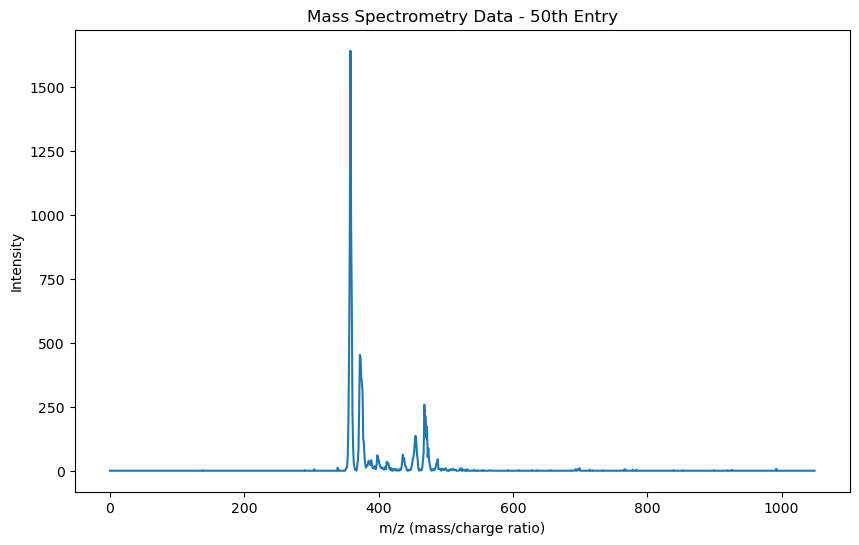

256
256
256
256
256


In [38]:
figure = new_spectra[1][0][70]
#print(len(figure))

for spectra in new_spectra:
    spectra = spectra[0:256]
    print(len(spectra))



## The next step is to generate this data for every cluster, and then train each mass cluster on it in the GANS, and then combine.

## Below is Ti02 Data Experimentation 

In [247]:
ti02 = training_dict['TiO2']
print(ti02.features.shape)

ti02.train_model(num_epochs = 5)
ti02.generate_classification_report('ti02_classification_report.csv')

ti02.train_model(num_epochs = 5)
ti02.generate_classification_report('ti02_classification_report.csv')

(2560, 1050)
Epoch: 0 Loss D.: 0.6929782629013062
Epoch: 0 Loss G.: 0.7411906719207764
Average Generator Loss over 5 Epochs: 2.2595458030700684
Average Discriminator Loss over 5 Epochs: 0.5644510388374329
Average Generator Accuracy from the last train: 0.28125
Average Discriminator Accuracy from the last train: 0.7352343749999999
Classification report saved to ti02_classification_report.csv


In [184]:
ti02.train_model(num_epochs = 80)

Epoch: 0 Loss D.: 0.6959182024002075
Epoch: 0 Loss G.: 0.7670994997024536
Epoch: 10 Loss D.: 0.5143333673477173
Epoch: 10 Loss G.: 1.0963597297668457
Epoch: 20 Loss D.: 0.3724256455898285
Epoch: 20 Loss G.: 1.5968283414840698
Epoch: 30 Loss D.: 0.3980618417263031
Epoch: 30 Loss G.: 6.532236099243164
Epoch: 40 Loss D.: 0.2510125935077667
Epoch: 40 Loss G.: 2.853494882583618
Epoch: 50 Loss D.: 0.2565086781978607
Epoch: 50 Loss G.: 2.650789260864258
Epoch: 60 Loss D.: 0.24858002364635468
Epoch: 60 Loss G.: 2.790785789489746
Epoch: 70 Loss D.: 0.20208057761192322
Epoch: 70 Loss G.: 5.356269359588623


In [185]:
ti02.generate_classification_report()

Average Generator Loss over 85 Epochs: 2.8603696823120117
Average Discriminator Loss over 85 Epochs: 0.328654021024704


In [214]:
ti02.train_model(num_epochs = 1)
ti02.export_models('ti02', 'ti02_models')

Epoch: 0 Loss D.: 0.7027968168258667
Epoch: 0 Loss G.: 0.7565817832946777
Models saved in directory: ti02_models


## Plot

     0  1  2  3  4  5  6  7  8  9  ...  1040  1041  1042  1043  1044  1045  \
225  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
226  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
227  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
228  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
229  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

     1046  1047  1048  1049  
225     0     0     0     0  
226     0     0     0     0  
227     0     0     0     0  
228     0     0     0     0  
229     0     0     0     0  

[5 rows x 1050 columns]


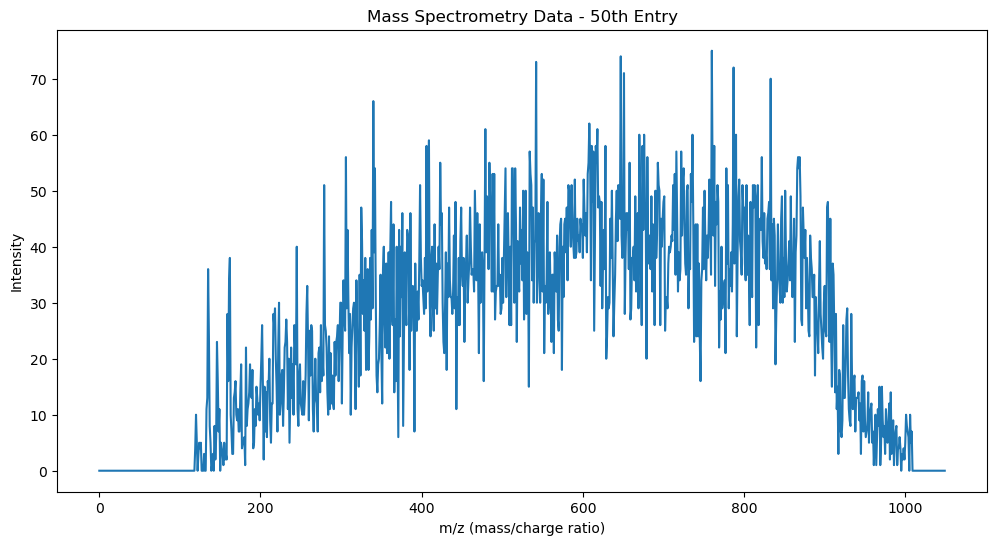

In [237]:
ti02.features.head()
ti02.display_features(226)

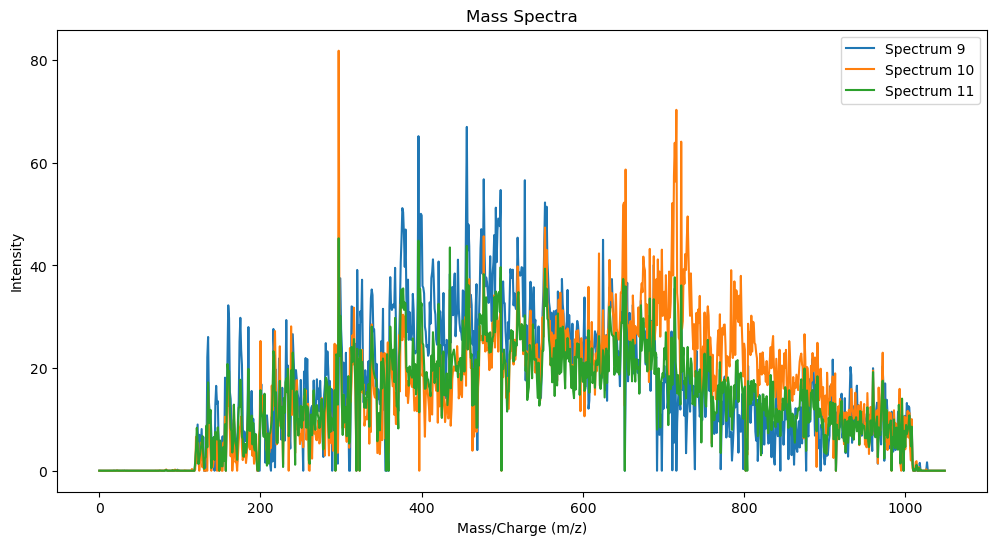

In [173]:
ti02.generate_samples(20)

In [ ]:
"""
## Note: I have an issue with understanding loss with WGANS, do not call classification report after training on wgans
    def train_model_wgans(self, num_epochs):
        discriminator = Discriminator()
        generator = Generator()
        self.generator = generator
        _, optimizer_d, optimizer_g = self.setup_optimizers(discriminator, self.generator)

        lambda_gp = 10  # Gradient penalty coefficient
        noise_dim = 100

        for epoch in range(num_epochs):
            for n, (real_samples, _) in enumerate(self.real_data_loader):
                

                for _ in range(5):  # Training discriminator more frequently than generator
                    fake_labels = torch.zeros(self.batch_size, 1)
                    real_labels = torch.ones(self.batch_size, 1)

                    latent_space_samples = torch.randn(self.batch_size, noise_dim)
                    generated_samples = generator(latent_space_samples)
                    
                    generated_samples = torch.tensor(generated_samples, dtype = torch.float32)
                    real_samples = torch.tensor(real_samples, dtype = torch.float32)
                    
                    d_real = discriminator(real_samples)
                    d_fake = discriminator(generated_samples)
                    gradient_penalty = self.compute_gradient_penalty(discriminator, real_samples, generated_samples)

                    loss_d = -torch.mean(d_real) + torch.mean(d_fake) + lambda_gp * gradient_penalty

                    optimizer_d.zero_grad()
                    loss_d.backward()
                    optimizer_d.step()

                # Training the generator
                latent_space_samples = torch.randn(self.batch_size, noise_dim)
                generated_samples = generator(latent_space_samples)
                d_fake = discriminator(generated_samples)

                loss_g = -torch.mean(d_fake)

                optimizer_g.zero_grad()
                loss_g.backward()
                optimizer_g.step()

                if epoch % 10 == 0 and n == 0:
                    print(f"Epoch: {epoch} Loss D.: {loss_d.item()}")
                    print(f"Epoch: {epoch} Loss G.: {loss_g.item()}")


def compute_gradient_penalty(self, D, real_samples, fake_samples):
        alpha = torch.rand(real_samples.size(0), 1, device=real_samples.device)
        alpha = alpha.expand(real_samples.size())
        interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
        interpolates = interpolates.requires_grad_(True)

        d_interpolates = D(interpolates)
        fake = torch.ones(d_interpolates.size(), device=real_samples.device)
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
"""
    
